### Main Code

In [1]:
import warnings


class Triangle:
    r"""
    An implementation of a triangle class.
    Note: Angles are assumed to be in radians, and are handled as such.

    The class can:
    * create a triangle with given set of angles/length of edges/some combination of lengths and angles
    * compute the area, circumference and center of mass
    * check whether the triangle is equilateral, isosceles or a right triangle
    * check whether two triangles are congruent or similar
    * compute angle bisector and perpendicular bisector
    * compute the incircle and circumcircle
    * compute the Euler line

    * plot the triangle
    * plot the center of mass
    * plot the angle bisector and the perpendicular bisector
    * plot incircle and circumcircle
    * plot the Euler line

    Alexandra Popova & Mark Woolley
    """

    # Creation
    def __init__(self, vertices=None, lengths=None, angles=None, inclination=0, arrangement=None):
        r"""
        INPUT:

        - "vertices" - a list of tuples or lists (default: None)
        - "lengths" - a list of floats (default: None)
        - "angles" - a list of floats (default: None)
        - "inclination" - float (default: 0)
        - "arrangement" - str (default: None)

        Notes about Inputs:
            Elements of "angles" and "inclination" will be interpreted as being measures in radians.
            "vertices", "lengths" and "angles" should each be of length at most 3.
            Will give a warning if "vertices" has more than 3 elements, but not for "lengths" and "angles".
            If too much information is given to construct a triangle, "vertices" take precedence over "lengths",
            which take precedence over "angles", and elements are dropped without giving a warning.
            "inclination" gives the angle between the first edge and the vector (1, 0) starting at the first vertex.
            If two or three points are given, inclination is silently ignored,
            and calculated during or after the construction.
            If no vertex is given, (0, 0) will be used as the starting vertex.
            Notes about "arrangement" can be found in "_check_arrangement()".

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: Triangle(vertices)
            [(0, 0), (2, 0), (0, 1)]

        ::

            sage: lengths = [2, sqrt(5), 1]
            sage: triangle = Triangle(lengths=lengths)
            sage: print(triangle)
            Triangle with vertices: [(0, 0), (2, 0), (0.000000000000000, 1.00000000000000)]
        """
        # defining variables
        self.x, self.y = var("x, y")

        # creating the triangle
        if vertices is None:
            # we need a basepoint when creating the triangle using lengths and angles.
            self.vertices = [(0, 0)]
        else:
            if len(vertices) > 3:
                warnings.warn('Expected "vertices" to be of length atmost 3, '
                              + 'will construct the triangle using the first 3 points.')
                vertices = vertices[:3]
            for vertex in vertices:
                if len(vertex) != 2:
                    raise Exception('Expected the elements of "vertices" to be two-dimensional, '
                                    + f'got {vertices}.')
            self.vertices = vertices[:]

        if len(self.vertices) < 3:
            arrangement = self._check_arrangement(self.vertices, lengths, angles, arrangement)
            self._create(lengths, angles, inclination, arrangement)

        # calculating basic properties
        self.vectors = self._calculate_vectors(self.vertices)
        self.lengths = self._calculate_lengths(self.vectors)
        self.angles = self._calculate_angles(self.vectors, self.lengths)
        self.inclination = self._calculate_inclination(self.vectors[0])
        self.plot_range = self._calculate_plot_range(self.vertices)

        # checking if the vectors sum up to (0, 0)
        sum_vector = sum(self.vectors)
        for k in range(2):
            if abs(sum_vector[k]) > 0.01:
                # should never happen
                raise Exception("Something went wrong while creating the triangle. "
                                + f"The sum of the vectors should be (0, 0) but is {sum_vector}.")

        # checking if the angles sum up to pi
        angle_sum = sum(self.angles)
        if abs(angle_sum/pi - 1) > 0.01:
            # should never happen
            raise Exception("Something went wrong while creating the triangle. "
                            + f"The sum of the inner angles should be pi but is {n(angle_sum)}.")

    def _check_arrangement(self, vertices=None, lengths=None, angles=None, arrangement=None):
        r"""
        Notes about "arrangement":
            If no arrangement is specified, a suitable arrangement will be chosen without giving a warning.
            To choose an arrangement, "vertices" take precedence over "lengths", which take precedence over "angles".
            If the arrangement is not compatible with the given input, a warning will be given,
            and it will be proceeded as if no arrangement was specified.
            If the arrangement contains 2 or 3 vertices, sides or angles it is assumed that the respective list
            is sorted in order to match the order of the arrangement.
            i.e. if "arrangement" is "VSAS" the first S is lengths[0], and the second S is lengths[1].
            If the arrangement contains 3 angles (and no side lengths), the first edge will have a length of 1.
            If no vertex is given, (0, 0) will be used as the starting vertex.

            Writing "S" for side, "A" for angle and "V" for vertex
            "S" defines the length of the side between two vertices
            "A" defines the angle between two sides

            Valid arrangements with vertices:
                "VVSS", "VVAS", "SVVS", "SAVV", "AVVA",
                "VSSS", "VSAS", "AVSA", "SAVS", "AVAA",

            Valid arrangements without vertices:
                "SSS",  "SAS",  "ASA",  "AAA"
            Which are interpreted as:
                "VSSS", "VSAS", "AVSA", "AVAA"

            If no arrangement is specified, the first valid arrangement from the following list will be chosen:
                "SVVS", "VVAS", "AVVA", "VSSS", "VSAS", "AVSA", "AVAA"


        EXAMPLES:

            sage: vertices = [(0, 0), (1, 0), (1, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle._check_arrangement([(4, -1)], [1, 1], [pi/2])
            "VSAS"

        ::

            sage: vertices = [(0, 0), (1, 0), (1, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle._check_arrangement([(4, -1)], [1, 1], [pi/2], "VVSS")
            /opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:173:
             \ UserWarning: The arrangement VVSS is not suitable for the given input,
             \ vertices = [(4, -1)], lengths = [1, 1], angles = [1/2*pi].
            "VSAS"

        ::
            sage: vertices = [(0, 0), (1, 0), (1, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle._check_arrangement([(4, -1)], [1, 1], [pi/2], "SAS")
            "VSAS"

        ::

            sage: vertices = [(0, 0), (1, 0), (1, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle._check_arrangement([(4, -1)], [1, 1])
            Exception: There exists no suitable arrangement for the given input.
             \ vertices = [(4, -1)], lengths = [1, 1], angles = None.
        """

        # counting the input parameters
        V_count = len(vertices) if vertices is not None else 0
        S_count = len(lengths) if lengths is not None else 0
        A_count = len(angles) if angles is not None else 0

        # checking if the specified arrangement is vaild and suitable for the given input
        if arrangement in ["VVSS", "VVAS", "AVVA", "SVVS", "SAVV", 
                           "VSSS", "AVAA", "VSAS", "AVSA", "SAVS",
                           "SSS",  "AAA",  "SAS",  "ASA"]:
            if arrangement in ["SSS", "SAS"]:
                arrangement = "V" + arrangement 
            if arrangement in ["ASA", "AAA"]:
                arrangement = "AV" + arrangement[1:]

            V_arr = arrangement.count("V")
            S_arr = arrangement.count("S")
            A_arr = arrangement.count("A")
            if (V_count >= V_arr) and (S_count >= S_arr) and (A_count >= A_arr):
                return arrangement
            else:
                warnings.warn(f"The arrangement {arrangement} is not suitable for the given input, "
                              + f"vertices = {vertices}, lengths = {lengths}, angles = {angles}.")

        # deciding on an arrangement
        if V_count == 2:
            if S_count >= 2:
                arrangement = "SVVS"
            elif S_count == 1 and A_count >= 1:
                arrangement = "VVAS"
            elif A_count >= 2:
                arrangement = "AVVA"
            else:
                arrangement = "Error"

        else:
            if S_count >= 3:
                arrangement = "VSSS"
            elif S_count == 2 and A_count >= 1:
                arrangement = "VSAS"
            elif S_count == 1 and A_count >= 2:
                arrangement = "AVSA"
            elif A_count >= 3:
                arrangement = "AVAA"
            else:
                arrangement = "Error"

        if arrangement == "Error":
            raise Exception("There exists no suitable arrangement for the given input. "
                            + f"vertices = {vertices}, lengths = {lengths}, angles = {angles}.")
        else:
            return arrangement

    def _create(self, lengths, angles, inclination, arrangement):
        r"""
        Creates the triangle according to arrangement and adds the computed vertices to "self.vertices".

        Should not be called explicitly, because Exceptions that would be caught in "_check_arrangement()",
        are not checked for here.
        """
        # reducing lengths and angles to the minimum required by the arrangment
        S_arr = arrangement.count("S")
        A_arr = arrangement.count("A")
        lengths = [] if lengths is None else lengths[:S_arr]
        angles = [] if angles is None else angles[:A_arr]
        inclination = 0 if inclination is None else inclination

        # checking wether the given lengths are valid for the chosen arrangement
        if "S" in arrangement:
            for length in lengths:
                if length <= 0:
                    raise Exception(f'Expected "lengths" to contain only positive values, got {lengths}.')

            if arrangement == "VSSS":
                total_lengths_halved = sum(lengths[:3])/2
                for k in lengths:
                    if k > total_lengths_halved:
                        raise Exception("Expected the sum of any two sides to be larger "
                                        + f"than the third side, got {lengths}.")

            if arrangement in ["SVVS", "VVSS"]:
                implicit = (vector(self.vertices[0])-vector(self.vertices[1])).norm()
                edge_lengths = lengths[:2] + [implicit]
                total_lengths_halved = sum(edge_lengths)/2
                for k in edge_lengths:
                    if k > total_lengths_halved:
                        raise Exception("Expected the sum of any two sides to be larger "
                                        + f"than the third side, got {lengths} and implicit length {implicit}.")

        # checking wether the given angles are valid for the chosen arrangement
        if "A" in arrangement:
            angles = [angle if angle > 0 else pi + angle for angle in angles]
            angle_sum = sum(angles[:3])
            if angle_sum > pi:
                raise ValueError(f'Expected the sum of "angles" to be less than pi, got {angle_sum}.')

            if arrangement == "AVAA":
                if abs(angle_sum/pi - 1) > 0.01:
                    raise ValueError(f'Expected the sum of "angles" to be equal to pi, got {angle_sum}.')

        # creating the second point
        if len(self.vertices) == 1:
            x_0, y_0 = self.vertices[0]

            # getting the distance from the basepoint to the second point
            if len(lengths) >= 1:
                if arrangement == "SAVS":
                    first_length = lengths.pop(1)
                else:
                    first_length = lengths.pop(0)
            else:
                first_length = 1

            # calculating the second point
            x_1 = x_0 + cos(inclination)*first_length
            y_1 = y_0 + sin(inclination)*first_length
            second_point = (x_1, y_1)
            self.vertices.append(second_point)

            # updating arrangement
            converter = {"VSSS": "VVSS",
                         "VSAS": "VVAS", "SAVS": "SAVV",
                         "AVSA": "AVVA",
                         "AVAA": "AVVA"}

            arrangement = converter[arrangement]

        # creating the third point
        if len(self.vertices) == 2:
            base_point = self.vertices[0]
            second_point = self.vertices[1]
            inclination = self._calculate_inclination(vector(base_point) - vector(second_point))

            # converting some arrangements into other arrangements
            if arrangement == "VVSS":
                lengths = [lengths[1], lengths[0]]
                arrangement = "SVVS"

            # constructing the curves for which the third point is an element of the intersection
            if arrangement == "SVVS":
                curve_0 = self.make_circle(lengths[0], base_point)
                curve_1 = self.make_circle(lengths[1], second_point)

            elif arrangement == "VVAS":
                curve_0 = self.make_circle(lengths[0], second_point)
                curve_1 = self.make_line(pi - angles[0] - inclination, second_point)

            elif arrangement == "SAVV":
                curve_0 = self.make_line(angles[0] + inclination, base_point)
                curve_1 = self.make_circle(lengths[0], base_point)

            elif arrangement == "AVVA":
                curve_0 = self.make_line(angles[0] + inclination, base_point)
                angle_1 = pi - angles[1] - inclination
                curve_1 = self.make_line(angle_1, second_point)

            # should never be entered, but one cannot be too sure
            else:
                raise ValueError(f'Unknown "arrangement": {arrangement}.')

            # getting the points of intersection
            intersection = self.get_intersection_point(curve_0, curve_1, True)

            # choosing the point with the highest y-value
            third_point = (intersection[0][x], intersection[0][y])
            if len(intersection) >= 1:
                for point in intersection[0:]:
                    if point[y] > third_point[1]:
                        third_point = (point[x], point[y])
            self.vertices.append(third_point)

        # making absolutely sure we have 3 points
        if len(self.vertices) != 3:
            raise Exception("Something went wrong during the creation of the triangle.")

    def _calculate_vectors(self, vertices):
        r"""
        Return the signed vectors between the given vertices in the given order.
        i.e. output[i] = self.vertices[i+1] - self.vertices[i]
        
        INPUT:

        - "vertices" - a list containing tuples or lists of length 2
        
        EXAMPLE:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle._calculate_vectors(vertices)
            [(2, 0), (-2, 1), (0, -1)]
        """
        length = len(vertices)
        vectors = [vector(vertices[(i+1)%length][j] - vertices[i][j]
                          for j in range(2))
                   for i in range(length)]

        for course in vectors:
            if course == vector((0, 0)):
                warnings.warn(f'Expected "vertices" to contain distinct elements, got {vertices}.')
        return vectors

    def _calculate_lengths(self, vectors):
        r"""
        Return the lengths of the given vectors.
        
        INPUT:

        - "vectors" - a list of elements with type vector
        
        EXAMPLE:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: vectors = [vector((2, 0)), vector((-2, 1)), vector((0, -1))]
            sage: triangle._calculate_lengths(vectors)
            [2, sqrt(5), 1]
        """
        lengths = [vec.norm() for vec in vectors]
        return lengths

    def _calculate_angles(self, vectors, lengths=None):
        r"""
        Return the angles enclosed by the triangle created by vectors.
        
        INPUT:

        - "vectors" - a list with 3 elements of  type vector
        - "lengths" - optional list composed of 3 integers (default: None)
        to get the expected angles in euclidean space lengths[i] needs to be equal to vectors[i].norm()
        
        EXAMPLE:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: vectors = [vector((2, 0)), vector((-2, 1)), vector((0, -1))]
            sage: lengths = triangle._calculate_lengths(vectors)
            sage: triangle._calculate_angles(vectors, lengths)
            [1/2*pi, arccos(2/5*sqrt(5)), arccos(1/5*sqrt(5))]
        """
        if lengths is None:
            lengths = self._calculate_lengths(vectors)

        for length in lengths:
            if length <= 0:
                raise ValueError(f'Expected "lengths" to contain only positive values, got {lengths}.')

        angles = []
        for k in range(3):
            numerator = -vectors[(k-1)%3].dot_product(vectors[k])
            denominator = lengths[(k-1)%3]*lengths[k]
            angle = arccos(numerator/denominator)
            angles.append(angle)
        return angles

    def _calculate_inclination(self, course):
        r"""
        Return the signed angle enclosed by course and the vector (1, 0).

        INPUT:

        - "course" - a vector of length 2

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: course = vector((1, 1))
            sage: triangle._calculate_inclination(course)
            arccos(1/2*sqrt(2))
        """
        inclination = arctan2(course[1], course[0])
        return inclination

    def _calculate_plot_range(self, vertices):
        r"""
        Return a suitable range for a plot containing this triangle.

        INPUT:

        - "vertices" - a list containing tuples or list of length 2
        
        EXAMPLE:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle._calculate_plot_range(vertices)
            {x: [], y: []}
        """
        # getting all x and y coordinates of vertices
        x_values = []
        y_values = [] 
        for (x, y) in vertices:
            x_values.append(x)
            y_values.append(y)

        # getting maxima and minima
        range_dict = {0: [min(x_values), max(x_values)],
                      1: [min(y_values), max(y_values)]}
        return range_dict


    # geometric functions
    def make_line(self, angle, point=None):
        r"""
        Return a polynomial defining a line through the given point with slope given by tan(angle).
        
        INPUT:

        - "angle" - float, interpreted as radians
        - "point" - optional tuple of length 2 (default: None)

        EXAMPLE:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_line(pi/4, (2, 0))
            x - y - 2

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_line(pi/2)
            x
        """
        if angle > 2*pi:
            raise ValueError(f'Expected "angle" to be less than 2*pi, got {angle}.')

        angle = min(angle, 2*pi - angle)

        if point is None:
            point = (0, 0)

        if abs(n(abs(angle) - pi/2)) > 0.01:
            return tan(angle)*(self.x - point[0]) + point[1] - self.y
        else:
            return self.x - point[0]

    def make_circle(self, radius, point=None):
        r"""
        Return a polynomial defining a circle with the given radius with point as center.
        
        INPUT:
        - "radius" - float
        - "point" - optional tuple of length 2 (default: None)

        EXAMPLE:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_circle(2, (2, 0))
            (x - 2)^2 + y^2 - 4

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_circle(-5)
            x^2 + y^2 - 25
        """
        if point is None:
            point = (0, 0)
        return (self.x - point[0])^2 + (self.y - point[1])^2 - radius^2

    def get_intersection_point(self, pol_0, pol_1, return_all=False):
        r"""
        Return one point in the intersection of the given polynomials.

        INPUT:

        - "pol_0" - polynomial in "self.x" and "self.y"
        - "pol_1" - polynomial in "self.x" and "self.y"
        - "return_all" - optional boolean (defualt: False)
        if True return all the intersections

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: line = triangle.make_line(pi/2)
            sage: circle = triangle.make_circle(2, (2, 0))
            sage: triangle.get_intersection_point(line, circle)
            (0, 0)
        """
        # getting the intersections by solving a system of 2 equations
        solutions = solve([pol_0, pol_1], self.x, self.y, solution_dict=True)

        # raising an error if no solution was found
        if solutions == {}:
            raise ValueError(f"No solution was found. Polynomials:\n{pol_0}\n{pol_1}")

        # returning one point in the intersection
        if return_all:
            return solutions
        coordinates = solutions[-1]
        return (coordinates[x], coordinates[y])


    # Dunder and Getter Functions
    def __repr__(self):
        r"""
        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: Triangle(vertices)
            [(0, 0), (2, 0), (0, 1)]
        """
        return str(self.vertices)

    def __str__(self):
        r"""
        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: print(triangle)
            Triangle with vertices: [(0, 0), (2, 0), (0, 1)]
        """
        return f"Triangle with vertices: {self.vertices}"

    def __eq__(self, other=None):
        r"""
        Return wether "self" and "other" have the same vertices.

        INPUT:

        - "other" - optional Triangle or other object (default: None)

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle_0 = Triangle(vertices)
            sage: triangle_1 = Traingle(vertices)
            sage: triangle_0 == triangle_1
            True
        """
        if not isinstance(other, Triangle):
            return False
        other_vertices = other.get_vertices()
        for vertex in other_vertices:
            if vertex not in self.vertices:
                return False
        return True

    def get_vertices(self):
        r""" 
        Return the vertices of the triangle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_vertices()
            [(0, 0), (2, 0), (0, 1)]
        """
        return self.vertices

    def get_vectors(self):
        r"""
        Return signed vectors between the vertices.
        
        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_vectors()
            [(2, 0), (-2, 1), (0, -1)]
        """
        return self.vectors

    def get_lengths(self):
        r""" 
        Return the lengths of the edges of the triangle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_lengths()
            [2, sqrt(5), 1]
        """
        return self.lengths

    def get_angles(self):
        r""" 
        Return the angles of the triangle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_angles()
            [1/2*pi, arccos(2/5*sqrt(5)), arccos(1/5*sqrt(5))]
        """
        return self.angles

    def get_inclination(self):
        r"""
        Return the inclination of the triangle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_inclination()
            0

        ::

            sage: vertices = [(0, 0), (1, 1), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_inclination()
            arccos(1/2*sqrt(2))
        """
        return self.inclination


    # Basic Properties
    def get_area(self):
        r""" 
        Return the area of the triangle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_area()
            1.00000000000000
        """
        s = self.get_circumference()/2
        area = n(sqrt(s*product(s - k for k in self.lengths)))
        return area

    def get_circumference(self):
        r""" 
        Return the circumference of the triangle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_circumference()
            sqrt(5) + 3
        """
        circumference = sum(self.lengths)
        return circumference

    def get_center_of_mass(self):
        r""" 
        Return the center of mass.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_center_of_mass()
            (2/3, 1/3)
        """
        mass_x = sum(vertex[0] for vertex in self.vertices)/3
        mass_y = sum(vertex[1] for vertex in self.vertices)/3
        center_of_mass = (mass_x, mass_y)
        return center_of_mass


    # Interesting Angles?
    def is_equilateral(self):
        r""" 
        Return wether the triangle is equilateral.

        EXAMPLES:

            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_0.is_equilateral()
            False

        ::

            sage: vertices_1 = [(-1, 0), (1, 0), (0, sqrt(3))]
            sage: triangle_1 = Triangle(vertices_1)
            sage: triangle_1.is_equilateral()
            True
        """
        lengths = [n(length) for length in self.lengths]
        for angle in self.angles:
            # we need some wiggle room due to not having infinite precision
            if abs(n(angle - pi/3)) > 0.001:
                return False
        return True

    def is_isosceles(self):
        r""" 
        Return wether the triangle is isosceles.

        EXAMPLES:

            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_0.is_isosceles()
            False

        ::

            sage: vertices_1 = [(-1, 0), (1, 0), (0, sqrt(3))]
            sage: triangle_1 = Triangle(vertices_1)
            sage: triangle_1.is_isosceles()
            True
        """
        for k in range(3):
            if self.angles[k] == self.angles[(k+1)%3]:
                return True
        return False

    def is_right_triangle(self):
        r""" 
        Return wether the triangle is a right triangle.

        EXAMPLES:

            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_0.is_right_triangle()
            True

        ::

            sage: vertices_1 = [(-1, 0), (1, 0), (0, sqrt(3))]
            sage: triangle_1 = Triangle(vertices_1)
            sage: triangle_1.is_right_triangle()
            False
        """
        for angle in self.angles:
            if abs(n(angle - pi/2)) < 0.001:
                return True
        return False


    # Comparisons
    def is_congruent(self, other=None):
        r"""
        Return whether "self" and "other" are congruent.

        INPUT:

        - "other" - optional Triangle or other object (default: None)
        
        EXAMPLES:
            
            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: vertices_1 = [(0, 0), (4, 0), (0, 2)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_1 = Triangle(vertices_1)
            sage: triangle_0.is_congruent(triangle_1)
            False

        ::

            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: vertices_2 = [(1, 1), (3, 1), (1, 2)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_2 = Triangle(vertices_2)
            sage: triangle_0.is_congruent(triangle_2)
            True

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.is_congruent()
            False
        """
        if not isinstance(other, Triangle):
            return False
        other_lengths = other.get_lengths()
        for length in other_lengths:
            if length not in self.lengths:
                return False
        return True

    def is_similar(self, other=None):
        r"""
        Return wether "self" and "other" are similar.

        INPUT:

        - "other" - optional Triangle or other object (default: None)
        
        EXAMPLES:
            
            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: vertices_1 = [(0, 0), (4, 0), (0, 2)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_1 = Triangle(vertices_1)
            sage: triangle_0.is_similar(triangle_1)
            True

        ::

            sage: vertices_0 = [(0, 0), (2, 0), (0, 1)]
            sage: vertices_2 = [(0, 0), (1, 0), (0, 1)]
            sage: triangle_0 = Triangle(vertices_0)
            sage: triangle_2 = Triangle(vertices_2)
            sage: triangle_0.is_similar(triangle_2)
            False

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.is_similar()
            False
        """
        if not isinstance(other, Triangle):
            return False
        other_angles = other.get_angles()
        for angle in other_angles:
            if angle not in self.angles:
                return False
        return True


    # Advanced Geometric Properties
    def get_angle_bisector(self, index=0):
        r"""
        Return the angle bisector at the specified vertex.

        INPUT:

        - "index" - optional integer (default: 0)

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_angle_bisector(0)
            x - y
        """
        index = index%3
        shift = (index-1)%3
        base_point = self.vertices[index]
        base_vector = vector(base_point)

        # constructing two points which have the same distance from the chosen vertex
        # and lie each on a line with the chosen vertex and another vertex
        point_0 = base_vector + self.vectors[index]/self.lengths[index]
        point_1 = base_vector - self.vectors[shift]/self.lengths[shift]

        # finding the midpoint between the two new points
        middle = (point_0 + point_1)/2

        # returning the line which passes through the chosen vertex and mid point
        course = middle - base_vector
        inclination = self._calculate_inclination(course)
        return self.make_line(inclination, base_point)

    def get_perpendicular_bisector(self, index=0):
        r"""
        Return the prependicular bisector of the specified edge.

        INPUT:

        - "index" - optional integer (default: 0)

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_perpendicular_bisector(0)
            1/275*sqrt(55)*sqrt(11)*sqrt(5)*(10*x + sqrt(55) - 10) - 1/5*sqrt(11)*sqrt(5) - y + 1/2
        """
        # constructing a circle at each end of the edge
        radius = self.lengths[index%3]
        circle_0 = self.make_circle(radius, self.vertices[(index-1)%3])
        circle_1 = self.make_circle(radius, self.vertices[(index+1)%3])

        # the line through the 2 intersection points is the perpendicular bisector
        intersections = self.get_intersection_point(circle_0, circle_1, True)
        point_0 = vector((intersections[0][x], intersections[0][y]))
        point_1 = vector((intersections[1][x], intersections[1][y]))

        # returning the bisector
        perp_section = point_1 - point_0
        inclination = self._calculate_inclination(perp_section)
        perpendicular_bisector = self.make_line(inclination, point_0)
        return perpendicular_bisector

    def get_incircle(self, polynomial=False):
        r"""
        Return the incircle (inscribed circle) of the triangle.

        INPUT:
        
        - "polynomial" - optional boolean (default: False)
        if True return the incircle as multivariate polynomial else return center and radius
        
        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_incircle()
            ((0.381966011250105, 0.381966011250105), 0.381966011250105)

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_incircle(True)
            1/4*(2*x + sqrt(5) - 3)^2 + 1/4*(2*y + sqrt(5) - 3)^2
            \ + 1/4*(sqrt(5) + 1)*(sqrt(5) - 1)*(sqrt(5) - 3)/(sqrt(5) + 3)
        """
        # bisecting two angles
        bisector_0 = self.get_angle_bisector(0)
        bisector_1 = self.get_angle_bisector(1)

        # their intersection is the center of the incircle
        center = self.get_intersection_point(bisector_0, bisector_1)

        # calcluating the radius
        a, b, c = self.lengths
        radius = (sqrt(((-a + b + c)*(a + b - c)*(a - b + c))/(a + b + c)))/2

        # returning the incircle in the wanted format
        if polynomial:
            return self.make_circle(radius, center)
        else:
            incircle = ((n(center[0]), n(center[1])), n(radius))
            return incircle

    def get_circumcircle(self, polynomial=False):
        r"""
        Return the circumcircle (circumscribed circle) of the triangle.

        INPUT:
        
        - "polynomial" - optional boolean (default: False)
        if True return the circumcircle as multivariate polynomial else return center and radius

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_circumcircle()
            ((1.00000000000000, 0.500000000000000), 1.11803398874989)

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_circumcircle(True)
            (x - 1)^2 + 1/4*(2*y - 1)^2 + 20/((sqrt(5) + 3)*(sqrt(5) + 1)*(sqrt(5) - 1)*(sqrt(5) - 3))
        """
        # bisecting two sides
        bisector_0 = self.get_perpendicular_bisector(0)
        bisector_1 = self.get_perpendicular_bisector(1)

        # their intersection is the center of the circumcircle
        center = self.get_intersection_point(bisector_0, bisector_1)

        # calcluating the radius
        a, b, c = self.lengths
        radius = (a*b*c)/sqrt(((-a + b + c)*(a + b - c)*(a - b + c)*(a + b + c)))

        # returning the circumcircle in the wanted format
        if polynomial:
            return self.make_circle(radius, center)
        else:
            circumcircle = ((n(center[0]), n(center[1])), n(radius))
            return circumcircle

    def get_euler_line(self):
        r"""
        Return the Euler line of the triangle.
        The Euler line passes besides other geometrically interesting points of the triangle,
        through the center of mass and the center of the incircle.

        EXAMPLES:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.get_euler_line()
            -0.553425250410629*x - y + 0.184475083470210
        """
        if self.is_equilateral():
            raise Exception("The triangle is equilateral, hence, the circumcenter and center of mass coincide. "
                            + "The Euler line is undefined in this case.")

        # getting the center of mass and the center of the incricle
        mass = self.get_center_of_mass()
        inci = self.get_incircle()[0]

        # returning the euler line
        course = vector(mass) - vector(inci)
        inclination = self._calculate_inclination(course)
        return self.make_line(inclination, mass)


    # plotting
    def plot(self, colour="blue", base_plot=None):
        r"""
        Return a plot with the triangle.

        INPUT:

        - "colour" - optional str (default: "blue")
        - "base_plot" - optional graphics object (default: None)
        if not None, the triangle will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: line_plot = line([(-1, 0), (2, 1)])
            sage: plot = triangle.plot("green", line_plot)
            sage: plot
        """
        triangle = line(self.vertices + self.vertices[:1], aspect_ratio=1.0, color=colour)

        if base_plot is not None:
            return base_plot + triangle
        return triangle

    def plot_center_of_mass(self, colour="purple", base_plot=None):
        r"""
        Return a plot with the center of mass.

        INPUT:

        - "dot_size" - optional int (default: 10)
        - "colour" - optional str (default: "purple")
        - "base_plot" - optional graphics object (default: None)
        if not None, the center of mass will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot_center_of_mass()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: tri_plot = triangle.plot()
            sage: plotted = triangle.plot_center_of_mass("red", tri_plot)
            sage: plotted
        """
        mass_center = self.get_center_of_mass()
        center_plot = point(mass_center, size=20, color=colour)

        if base_plot is not None:
            return base_plot + center_plot
        return center_plot

    def make_polynomial_plottable(self, polynomial):
        r"""
        Return a tuple suitable for parametric_plot() representing the function polynomial,
        alongside a suitable range to plot with the triangle in frame.

        INPUT:

        - "polynomial" - a multivariate polynomial in x and y

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_polynomial_plottable(x^2 - y)
            ((x, x^2), [0, 2])

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_polynomial_plottable(x - 1)
            ((1, x), [0, 1])
            
        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.make_polynomial_plottable(y - 1)
            ((x, 1), [0, 2])
        """
        # if the polynomial has y as a variable
        try:
            solution = solve(polynomial, y)[0].rhs()
            function = (self.x, solution)
            plot_range = self.plot_range[0]

        # if the polynomial is purely in x
        except IndexError:
            solution = solve(polynomial, x)[0].rhs()
            function = (solution, self.x)
            plot_range = self.plot_range[1]

        # return the parametric function with a suitable range
        return function, plot_range

    def plot_angle_bisector(self, index=0, colour="red", base_plot=None):
        r"""
        Return a plot with the angle_bisector at the specified vertex.

        INPUT:

        - "index" - optional int (default: 0)
        - "colour" - optional str (default: "red")
        - "base_plot" - optional graphics object (default: None)
        if not None, the angle bisector will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot_angle_bisector()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: tri_plot = triangle.plot()
            sage: plotted = triangle.plot_angle_bisector(1, [-1, 3], [-1, 2], "red", tri_plot)
            sage: plotted
        """
        bisector_poly = self.get_angle_bisector(index)
        bisector_func, plot_range = self.make_polynomial_plottable(bisector_poly)
        bisector_plot = parametric_plot(bisector_func, plot_range, color=colour)

        if base_plot is not None:
            return base_plot + bisector_plot
        return bisector_plot

    def plot_perpendicular_bisector(self, index=0, colour="red", base_plot=None):
        r"""
        Return a plot with the prependicular bisector of the specified edge.

        INPUT:

        - "index" - optional int (default: 0)
        - "colour" - optional str (default: "red")
        - "base_plot" - optional graphics object (default: None)
        if not None, the perpendicular bisector will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot_perpendicular_bisector()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: tri_plot = triangle.plot()
            sage: plotted = triangle.plot_perpendicular_bisector(1, [-1, 3], "red", tri_plot)
            sage: plotted
        """
        bisector_poly = self.get_perpendicular_bisector(index)
        bisector_func, plot_range = self.make_polynomial_plottable(bisector_poly)
        bisector_plot = parametric_plot(bisector_func, plot_range, color=colour)

        if base_plot is not None:
            return base_plot + bisector_plot
        return bisector_plot

    def plot_incircle(self, center=False, colour="green", base_plot=None):
        r"""
        Return a plot with the incircle (inscribed circle).

        INPUT:

        - "center" - optional boolean (default: False)
        if True, the center will also be plotted
        - "colour" - optional str (default: "green")
        - "base_plot" - optional graphics object (default: None)
        if not None, the incircle will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot_incircle()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: tri_plot = triangle.plot()
            sage: plotted = triangle.plot_incircle("red", tri_plot)
            sage: plotted
        """
        center, radius = self.get_incircle()
        incircle_plot = circle(center, radius, color=colour)

        if center:
            incircle_plot += point(center, size=20, color=colour)

        if base_plot is not None:
            return base_plot + incircle_plot
        return incircle_plot

    def plot_circumcircle(self, center=False, colour="green", base_plot=None):
        r"""
        Return a plot with the circumcircle (circumscribed circle).

        INPUT:

        - "center" - optional boolean (default: False)
        if True, the center will also be plotted 
        - "colour" - optional str (default: "green")
        - "base_plot" - optional graphics object (default: None)
        if not None, the circumcircle will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot_circumcircle()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: tri_plot = triangle.plot()
            sage: plotted = triangle.plot_circumcircle("red", tri_plot)
            sage: plotted
        """
        center, radius = self.get_circumcircle()
        circumcircle_plot = circle(center, radius, color=colour)

        if center:
            circumcircle_plot += point(center, size=20, color=colour)

        if base_plot is not None:
            return base_plot + circumcircle_plot
        return circumcircle_plot

    def plot_euler_line(self, colour="purple", base_plot=None):
        r"""
        Return a plot with the euler line.

        INPUT:

        - "colour" - optional str (default: "purple")
        - "base_plot" - optional graphics object (default: None)
        if not None, the euler line  will be added to the plot.

        PLOT:

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: triangle.plot_euler_line()

        ::

            sage: vertices = [(0, 0), (2, 0), (0, 1)]
            sage: triangle = Triangle(vertices)
            sage: tri_plot = triangle.plot()
            sage: plotted = triangle.plot_euler_line("red", tri_plot)
            sage: plotted
        """
        euler_poly = self.get_euler_line()
        euler_func, plot_range = self.make_polynomial_plottable(euler_poly)
        euler_plot = parametric_plot(euler_func, plot_range, color=colour)

        if base_plot is not None:
            return base_plot + euler_plot
        return euler_plot

### Example sessions

**Properties**

In [2]:
vertices = [(0, 0), (2, 0), (0, 1)]
triangle = Triangle(vertices)
print(triangle)

lengths = triangle.get_lengths()
print(f"The triangle has side lengths {lengths}.")
angles = triangle.get_angles()
numerical_approximations = [round(n(angle), 4) for angle in angles]
print(f"And its angles are {angles} which are roughly {numerical_approximations}.")

print(f"\nIt has an area of {triangle.get_area()}.")
print(f"It has a circumference of {triangle.get_circumference()}.")
print(f"Its center of mass is located at {triangle.get_center_of_mass()}.")

print(f"\nIs the triangle a right triangle? {triangle.is_right_triangle()}.")
print(f"Is the triangle isosceles? {triangle.is_isosceles()}.")
print(f"Is the triangle equilateral? {triangle.is_equilateral()}.")

Triangle with vertices: [(0, 0), (2, 0), (0, 1)]
The triangle has side lengths [2, sqrt(5), 1].
And its angles are [1/2*pi, arccos(2/5*sqrt(5)), arccos(1/5*sqrt(5))] which are roughly [1.5708, 0.4636, 1.1071].

It has an area of 1.00000000000000.
It has a circumference of sqrt(5) + 3.
Its center of mass is located at (2/3, 1/3).

Is the triangle a right triangle? True.
Is the triangle isosceles? False.
Is the triangle equilateral? False.


**Comparison of some triangles.**

Are the blue and green triangle similar? True
Are the blue and green triangle congruent? False
Are the blue and purple triangle congurent? True


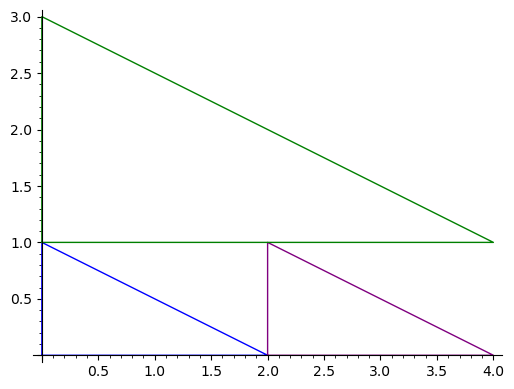

In [3]:
blue_ver = [(0, 0), (2, 0), (0, 1)]
blue = Triangle(blue_ver)
plotted = blue.plot("blue")

purple_ver = [(2, 0), (4, 0), (2, 1)]
purple = Triangle(purple_ver)
plotted = purple.plot("purple", plotted)

green_ver = [(0, 1), (4, 1), (0, 3)]
green = Triangle(green_ver)
plotted = green.plot("green", plotted)

print(f"Are the blue and green triangle similar? {blue.is_similar(green)}")
print(f"Are the blue and green triangle congruent? {blue.is_congruent(green)}")
print(f"Are the blue and purple triangle congurent? {blue.is_congruent(purple)}")

plotted

**Plotting the incircle with the angle bisectors.**

Is the tiangle isosceles? True


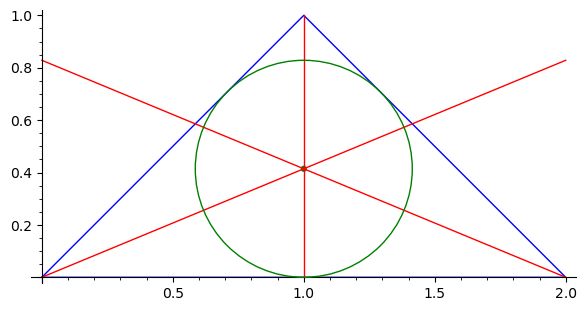

In [4]:
vertices = [(0, 0), (2, 0), (1, 1)]
triangle = Triangle(vertices)
print(f"Is the tiangle isosceles? {triangle.is_isosceles()}")
plotted = triangle.plot()
plotted = triangle.plot_angle_bisector(0, base_plot=plotted)
plotted = triangle.plot_angle_bisector(1, base_plot=plotted)
plotted = triangle.plot_angle_bisector(2, base_plot=plotted)
triangle.plot_incircle(base_plot=plotted)

**Plotting the circumcircle with the perpendicular bisectors.**

Is the triangle equilateral? True


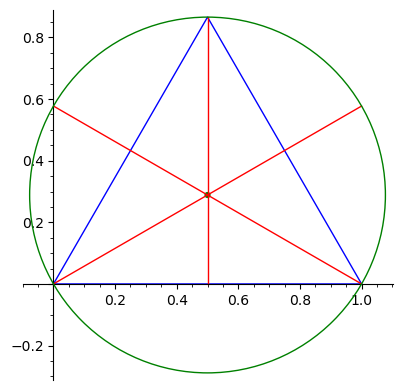

In [5]:
vertices = [(0, 0), (1, 0), (1/2, sqrt(3)/2)]
triangle = Triangle(vertices)
print(f"Is the triangle equilateral? {triangle.is_equilateral()}")
plotted = triangle.plot()
plotted = triangle.plot_perpendicular_bisector(0, base_plot=plotted)
plotted = triangle.plot_perpendicular_bisector(1, base_plot=plotted)
plotted = triangle.plot_perpendicular_bisector(2, base_plot=plotted)
triangle.plot_circumcircle(base_plot=plotted)

**Plotting the center of mass, incircle and the Euler line**

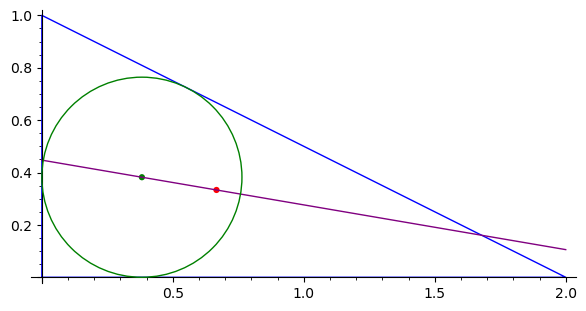

In [6]:
vertices = [(0, 0), (2, 0), (0, 1)]
triangle = Triangle(vertices)
plotted = triangle.plot()
plotted = triangle.plot_center_of_mass("red", base_plot=plotted)
plotted = triangle.plot_incircle(center=True, base_plot=plotted)
triangle.plot_euler_line(base_plot=plotted)

**Creating some triangles using default arrangements**

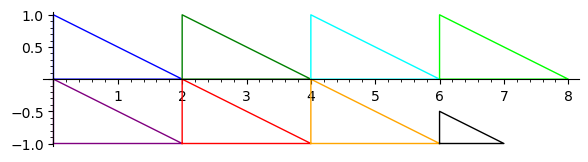

In [7]:
# three vertices
vertices = [(0, 0), (2, 0), (0, 1)]
triangle_0 = Triangle(vertices)
plotted = triangle_0.plot()

lengths = triangle_0.get_lengths()
angles = triangle_0.get_angles()

# two vertices and two side lengths: "SVVS"
triangle_1 = Triangle([(0, -1), (2, -1)], list(reversed(lengths)))
plotted = triangle_1.plot("purple", plotted)

# two vertices, one side length and one angle: "VVAS"
triangle_2 = Triangle([(2, 0), (4, 0)], [lengths[1]], [angles[1]])
plotted = triangle_2.plot("green", plotted)

# two vertices and two angles: "AVVA"
triangle_3 = Triangle([(2, -1), (4, -1)], angles=angles)
plotted = triangle_3.plot("red", plotted)
plotted

# one vertex and three side lengths: "VSSS"
triangle_4 = Triangle([(4, 0)], lengths=lengths)
plotted = triangle_4.plot("cyan", plotted)

# one vertex, two side lengths and one angle: "VSAS"
triangle_5 = Triangle([(4, -1)], lengths[:2], [angles[1]])
plotted = triangle_5.plot("orange", plotted)

# one vertex, one side length and two angles: "AVSA"
triangle_2 = Triangle([(6, 0)], [lengths[0]], angles)
plotted = triangle_2.plot("lime", plotted)

# one vertex and three angles: "AVAA"
triangle_4 = Triangle([(6, -1)], angles=angles)
plotted = triangle_4.plot("black", plotted)

plotted

**Creating some triangles using the other arrangements**

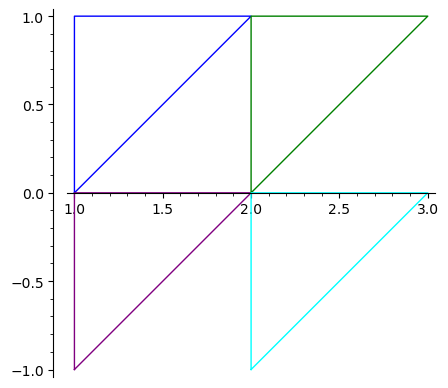

In [8]:
# three vertices
vertices = [(1, 0), (2, 1), (1, 1)]
triangle_10 = Triangle(vertices)
plotted = triangle_10.plot()

lengths = triangle_10.get_lengths()
angles = triangle_10.get_angles()
incl = triangle_10.get_inclination()

# two vertices and two side lengths: "VVSS"
triangle_11 = Triangle([(1, -1), (2, 0)], lengths[1:], arrangement="VVSS")
plotted = triangle_11.plot("purple", plotted)

# two vertices, one side length and one angle: "SAVV"
triangle_12 = Triangle([(2, 0), (3, 1)], [lengths[2]], [angles[0]], incl, "SAVV")
plotted = triangle_12.plot("green", plotted)

# one vertex, two side lengths and one angle: "SAVS"
triangle_14 = Triangle([(2, -1)], [lengths[2], lengths[0]], angles, incl, "SAVS")
plotted = triangle_14.plot("cyan", plotted)

plotted

### Testing the implementation

In [9]:
# for testing
from unittest import TestCase, main

# Note: some functions were "tested" visually and have hence no test cases
class TriangleTests(TestCase):
    @classmethod
    def setUpClass(cls):
        super(TriangleTests, cls).setUpClass()
        warnings.filterwarnings("error")

    def setUp(self):
        self.right_vertices = [(0, 0), (2, 0), (0, 1)]
        self.right = Triangle(self.right_vertices)

        self.iso_vertices = [(-1, 0), (1, 0), (0, 1)]
        self.isosceles = Triangle(self.iso_vertices)


    # testing _check_arrangement
    def test_check_arrangement_error(self):
        base_point = [(0, 0)]

        with self.assertRaises(Warning):
            self.right._check_arrangement(base_point, arrangement="VSSS")

        with self.assertRaises(Exception):
            self.right._check_arrangement(base_point)
        
    def test_check_arrangement_two_vertices(self):
        lengths = [1, sqrt(2), 1]
        angles = [pi/2, pi/4, pi/4]

        two_vertices = [(0, 0), (1, 0)]
        two_lengths = lengths[:2]

        base_length = lengths[:1]
        base_angle = angles[:1]

        expected_VVSS = "VVSS"
        actual_given_VVSS = self.right._check_arrangement(vertices=two_vertices, lengths=two_lengths,
                                                          arrangement="VVSS")
        self.assertEqual(expected_VVSS, actual_given_VVSS)

        expected_SVVS = "SVVS"
        actual_given_SVVS = self.right._check_arrangement(vertices=two_vertices, lengths=two_lengths,
                                                          angles=angles, arrangement="SVVS")
        self.assertEqual(expected_SVVS, actual_given_SVVS)

        actual_omitted_SVVS = self.right._check_arrangement(vertices=two_vertices, lengths=lengths)
        self.assertEqual(expected_SVVS, actual_omitted_SVVS)

        expected_VVAS = "VVAS"
        actual_given_VVAS = self.right._check_arrangement(vertices=two_vertices, lengths=base_length,
                                                          angles=base_angle, arrangement="VVAS")
        self.assertEqual(expected_VVAS, actual_given_VVAS)

        actual_omitted_VVAS = self.right._check_arrangement(vertices=two_vertices, lengths=base_length,
                                                            angles=angles)
        self.assertEqual(expected_VVAS, actual_omitted_VVAS)

        expected_SAVV = "SAVV"
        actual_given_SAVV = self.right._check_arrangement(vertices=two_vertices, lengths=base_length,
                                                          angles=base_angle, arrangement="SAVV")
        self.assertEqual(expected_SAVV, actual_given_SAVV)

        expected_AVVA = "AVVA"
        actual_given_AVVA = self.right._check_arrangement(vertices=two_vertices,
                                                          angles=angles, arrangement="AVVA")
        self.assertEqual(expected_AVVA, actual_given_AVVA)

        actual_omitted_AVVA = self.right._check_arrangement(vertices=two_vertices, angles=angles)
        self.assertEqual(expected_AVVA, actual_omitted_AVVA)
        
    def test_check_arrangement_one_vertex(self):
        lengths = [1, sqrt(2), 1]
        angles = [pi/2, pi/4, pi/4]

        two_lengths = lengths[:2]

        base_point = [(0, 0)]
        base_length = lengths[:1]
        base_angle = angles[:1]

        expected_VSSS = "VSSS"
        actual_given_VSSS = self.right._check_arrangement(vertices=base_point, lengths=lengths,
                                                          arrangement="VSSS")
        self.assertEqual(expected_VSSS, actual_given_VSSS)

        actual_omitted_VSSS = self.right._check_arrangement(vertices=base_point, lengths=lengths)
        self.assertEqual(expected_VSSS, actual_omitted_VSSS)

        expected_VSAS = "VSAS"
        actual_given_VSAS = self.right._check_arrangement(vertices=base_point, lengths=two_lengths,
                                                          angles=angles, arrangement="VSAS")
        self.assertEqual(expected_VSAS, actual_given_VSAS)

        actual_omitted_VSAS = self.right._check_arrangement(vertices=base_point, lengths=two_lengths,
                                                            angles=base_angle)
        self.assertEqual(expected_VSAS, actual_omitted_VSAS)


        expected_SAVS = "SAVS"
        actual_given_SAVS = self.right._check_arrangement(vertices=base_point, lengths=lengths,
                                                          angles=base_angle, arrangement="SAVS")
        self.assertEqual(expected_SAVS, actual_given_SAVS)

        expected_AVSA = "AVSA"
        actual_given_AVSA = self.right._check_arrangement(vertices=base_point, lengths=two_lengths,
                                                          angles=angles, arrangement="AVSA")
        self.assertEqual(expected_AVSA, actual_given_AVSA)

        actual_omitted_AVSA = self.right._check_arrangement(vertices=base_point, lengths=base_length,
                                                            angles=angles)
        self.assertEqual(expected_AVSA, actual_omitted_AVSA)

        expected_AVAA = "AVAA"
        actual_given_AVAA = self.right._check_arrangement(vertices=base_point, angles=angles,
                                                          arrangement="AVAA")
        self.assertEqual(expected_AVAA, actual_given_AVAA)

        actual_omitted_AVAA = self.right._check_arrangement(vertices=base_point, angles=angles)
        self.assertEqual(expected_AVAA, actual_omitted_AVAA)

    def test_check_arrangement_without_vertex(self):
        lengths = [1, sqrt(2), 1]
        angles = [pi/2, pi/4, pi/4]

        two_lengths = lengths[:2]

        base_point = [(0, 0)]
        base_length = lengths[:1]
        base_angle = angles[:1]

        expected_VSSS = "VSSS"
        actual_given_SSS = self.right._check_arrangement(vertices=base_point, lengths=lengths,
                                                         arrangement="SSS")
        self.assertEqual(expected_VSSS, actual_given_SSS)

        expected_VSAS = "VSAS"
        actual_given_SAS = self.right._check_arrangement(vertices=base_point, lengths=two_lengths,
                                                         angles=angles, arrangement="SAS")
        self.assertEqual(expected_VSAS, actual_given_SAS)

        expected_AVSA = "AVSA"
        actual_given_ASA = self.right._check_arrangement(vertices=base_point, lengths=two_lengths,
                                                         angles=angles, arrangement="ASA")
        self.assertEqual(expected_AVSA, actual_given_ASA)

        expected_AVAA = "AVAA"
        actual_given_AAA = self.right._check_arrangement(vertices=base_point, angles=angles,
                                                         arrangement="AAA")
        self.assertEqual(expected_AVAA, actual_given_AAA)


    # testing calculating and getter functions
    def test_vectors(self):
        expected_right = [vector((2, 0)), vector((-2, 1)), vector((0, -1))]
        actual_right = self.right.get_vectors()
        self.assertEqual(expected_right, actual_right)

        expected_iso = [vector((2, 0)), vector((-1, 1)), vector((-1, -1))]
        actual_iso = self.isosceles.get_vectors()
        self.assertEqual(expected_iso, actual_iso)

    def test_lengths(self):
        expected_right = [2, sqrt(5), 1]
        actual_right = self.right.get_lengths()
        self.assertEqual(expected_right, actual_right)

        expected_iso = [2, sqrt(2), sqrt(2)]
        actual_iso = self.isosceles.get_lengths()
        self.assertEqual(expected_iso, actual_iso)

    def test_angles(self):
        expected_right = [pi/2, arccos(2/sqrt(5)), arccos(1/sqrt(5))]
        actual_right = self.right.get_angles()
        self.assertEqual(3, len(actual_right))
        self.assertEqual(expected_right, actual_right)

        expected_iso = [arccos(1/2*sqrt(2)), arccos(1/2*sqrt(2)), pi/2]
        actual_iso = self.isosceles.get_angles()
        self.assertEqual(expected_iso, actual_iso) 

    def test_inclination(self):
        expected_right = 0
        actual_right = self.right.get_inclination()
        self.assertEqual(expected_right, actual_right)

        expected_con = n(pi/4)
        constructed = Triangle([(0, 0), (1, 1), (0, 1)])
        actual_con = n(constructed.get_inclination())
        self.assertEqual(expected_con, actual_con)

    def test_calculate_inclination(self):
        tests = {(2, 0): 0,
                 (1, 1): n(pi/4),
                 (0, 1): n(pi/2),
                 (-3, 3): n(3*pi/4),
                 (-5, 0): n(pi),
                 (-1, -1): -n(3*pi/4),
                 (0, -1): -n(pi/2),
                 (2, -2): -n(pi/4)}
        for (point, expected) in tests.items():
            course = vector(point)
            actual = n(self.right._calculate_inclination(course))
            self.assertEqual(expected, actual)

    # testing dunder functions
    def test_repr(self):
        expected_right = str(self.right_vertices)
        actual_right = repr(self.right)
        self.assertEqual(expected_right, actual_right)

        expected_iso = str(self.iso_vertices)
        actual_iso = repr(self.isosceles)
        self.assertEqual(expected_iso, actual_iso)

    def test_str(self):
        expected_right = f"Triangle with vertices: {self.right_vertices}"
        actual_right = str(self.right)
        self.assertEqual(expected_right, actual_right)

        expected_iso = f"Triangle with vertices: {self.iso_vertices}"
        actual_iso = str(self.isosceles)
        self.assertEqual(expected_iso, actual_iso)

    def test_eq(self):
        expected_right_iso = False
        actual_right_iso = self.right == self.isosceles
        self.assertEqual(expected_right_iso, actual_right_iso)
    
        expected_iso_iso = True
        actual_iso_iso = self.isosceles == self.isosceles
        self.assertEqual(expected_iso_iso, actual_iso_iso)


    # testing curve functions
    def test_make_line(self):
        x, y = var("x, y")

        expected_45 = x - y
        actual_45 = self.right.make_line(pi/4, (0, 0))
        self.assertEqual(expected_45, actual_45)

        expected_90 = x - 1
        actual_90 = self.right.make_line(pi/2, (1, 2))
        self.assertEqual(expected_90, actual_90)

    def test_make_circle(self):
        x, y = var("x, y")

        expected_two = x^2 + y^2 - 4
        actual_two = self.right.make_circle(2, (0, 0))
        self.assertEqual(expected_two, actual_two)

        expected_three = (x - 1)^2 + (y - 1)^2 - 9
        actual_three = self.right.make_circle(3, (1, 1))
        self.assertEqual(expected_three, actual_three)

        expected_four = (x)^2 + (y)^2 - 16
        actual_four = self.right.make_circle(-4)
        self.assertEqual(expected_four, actual_four)

    def test_get_angle_bisector(self):
        x, y = var("x, y")

        expected_right = x - y
        actual_right = self.right.get_angle_bisector(0)
        self.assertEqual(expected_right, actual_right)

        expected_iso = x
        actual_iso = self.isosceles.get_angle_bisector(2)
        self.assertEqual(expected_iso, actual_iso)


    # testing actual functionality
    def test_circumference(self):
        expected_right = 2 + sqrt(5) + 1
        actual_right = self.right.get_circumference()
        self.assertEqual(expected_right, actual_right)

        expected_iso = 2 + 2*sqrt(2)
        actual_iso = self.isosceles.get_circumference()
        self.assertEqual(expected_iso, actual_iso)

    def test_get_area(self):
        expected_right = 1
        actual_right = self.right.get_area()
        self.assertEqual(expected_right, actual_right)

        expected_iso = 1
        actual_iso = round(self.isosceles.get_area(), 5)
        self.assertEqual(expected_iso, actual_iso)

    def test_center_of_mass(self):
        expected_right = (2/3, 1/3)
        actual_right = self.right.get_center_of_mass()
        self.assertEqual(expected_right, actual_right)

        expected_iso = (0, 1/3)
        actual_iso = self.isosceles.get_center_of_mass()
        self.assertEqual(expected_iso, actual_iso)

    def test_is_equilateral(self):
        expected_right = False
        actual_right = self.right.is_equilateral()
        self.assertEqual(expected_right, actual_right)

        expected_equi = True
        equilateral = Triangle([(-1, 0), (1, 0), (0, sqrt(3))])
        actual_equi = equilateral.is_equilateral()
        self.assertEqual(expected_equi, actual_equi)

    def test_is_isosceles(self):
        expected_right = False
        actual_right = self.right.is_isosceles()
        self.assertEqual(expected_right, actual_right)

        expected_iso = True
        actual_iso = self.isosceles.is_isosceles()
        self.assertEqual(expected_iso, actual_iso)

    def test_is_right_triangle(self):
        expected_right = True
        actual_right = self.right.is_right_triangle()
        self.assertEqual(expected_right, actual_right)

        expected_iso = True
        actual_iso = self.isosceles.is_right_triangle()
        self.assertEqual(expected_iso, actual_iso)

    # testing comparisons
    def test_is_congruent(self):
        expected_right_iso = False
        actual_right_iso = self.right.is_congruent(self.isosceles)
        self.assertEqual(expected_right_iso, actual_right_iso)

        expected_righteous = True
        righteous = Triangle([(1, 1), (1, 3), (2, 1)])
        actual_righteous = self.right.is_congruent(righteous)
        self.assertEqual(expected_righteous, actual_righteous)

    def test_is_similar(self):
        expected_right_iso = False
        actual_right_iso = self.right.is_similar(self.isosceles)
        self.assertEqual(expected_right_iso, actual_right_iso)

        expected_righteous = True
        righteous = Triangle([(0, 0), (0, 4), (2, 0)])
        actual_righteous = self.right.is_similar(righteous)
        self.assertEqual(expected_righteous, actual_righteous)


# runs all the defined tests
main(argv=["first-arg-is-ignored"], exit=False)

.......................
----------------------------------------------------------------------
Ran 23 tests in 0.534s

OK
